In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import random as ran
from IPython.display import clear_output
from src import spotify, dp, utils, DB
from sklearn.metrics.pairwise import euclidean_distances as euc
import pandas as pd
import math as mt
import numpy as np

db = DB()

# K Checking
- 새로운 K의 갯수를 만들 수 있는지 확인하는 과정

In [3]:
seed_musics = db.seed_zone.estimated_document_count()
K = round(mt.sqrt(seed_musics / 2))
print("현재 seed 음악 갯수 : {}".format(seed_musics))
print("K 갯수 : {}".format(K))

현재 seed 음악 갯수 : 334
K 갯수 : 13


In [4]:
_seed_features = db.seed_zone.find({})
seed_features = pd.DataFrame([_ for _ in _seed_features])

seed_features.drop(["_id"], axis=1, inplace=True)
seed_features.rename({"track_id": "id"}, axis=1,inplace=True)

seed_features.head()

,id,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,7tIOwGFRTM08JdAeKOELGp,0.632,0.0378,5,-20.596,0.0583,0.9890,0.935000,0.1120,0.357,121.361
1,3UPjb91Fwm7u2tAm92Bk0p,0.554,0.5260,7,-5.210,0.0394,0.8080,0.000000,0.0740,0.230,129.845
2,3dbLT62Cvs46Ju7a8gpr36,0.727,0.8790,9,-1.167,0.1290,0.1240,0.000012,0.2440,0.671,146.959
3,2FWquqPNxte8iqZ3ATQG0p,0.403,0.7240,8,-6.064,0.2460,0.3770,0.000000,0.0927,0.428,97.133
4,3gzIK2dGSVvPBiohsTwEWZ,0.639,0.5690,0,-7.236,0.0487,0.0581,0.000169,0.1080,0.616,142.967


# Make Norm Features

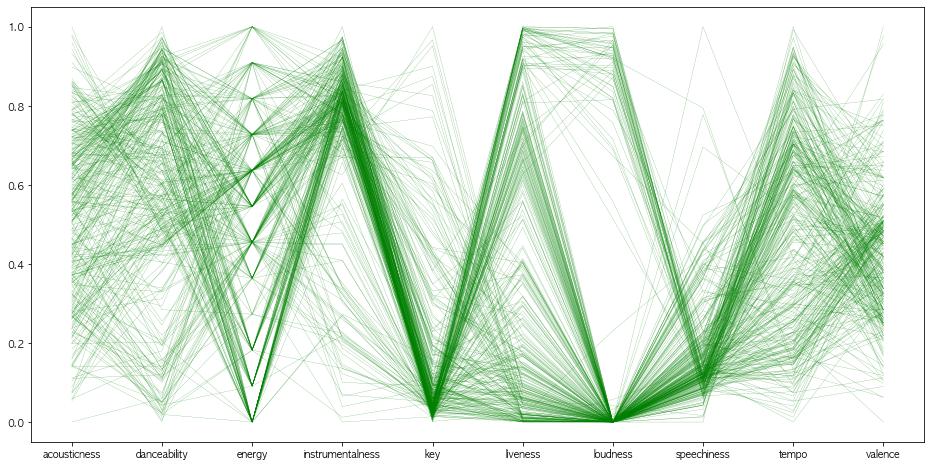

In [6]:
norm_features = dp.make_norm(seed_features)

utils.visual_norm_data(None, norm_features)

# KMeans Run

sorting okay


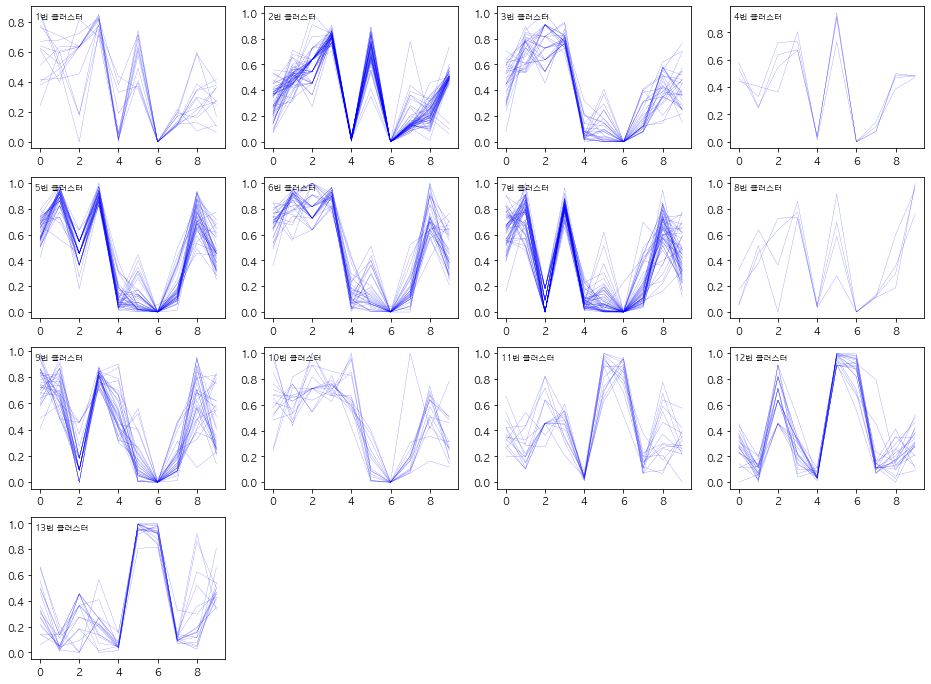

In [8]:
kmeans = utils.KMeans(
    datas=norm_features
)
kmeans.run(early_stop_cnt=5)

clear_output(wait=True)

kmeans.sorting()
utils.visual_cluster_data(norm_features, kmeans)

# Mail Box Matching

In [100]:
ms = utils.MatchingSystem(
    norm_features = norm_features,
    kmeans = kmeans
)

ms.music_label.head()

,track_id,label
0,7tIOwGFRTM08JdAeKOELGp,12
1,3UPjb91Fwm7u2tAm92Bk0p,1
2,3dbLT62Cvs46Ju7a8gpr36,5
3,2FWquqPNxte8iqZ3ATQG0p,9
4,3gzIK2dGSVvPBiohsTwEWZ,6


In [63]:
_mail_boxes = db.mail_box.find()
mail_boxes = [_ for _ in _mail_boxes]

mail_box_radar = pd.DataFrame(columns=set(_label))

for target_mail_box in mail_boxes:
    target = pd.DataFrame(target_mail_box['tracks'])
    target_label_info = pd.merge(target, music_label,
        on='track_id')
    group_cnt = target_label_info.groupby(['label']).count()['track_id']
    
    mail_box_radar.loc[str(target_mail_box['_id'])] = (group_cnt / len(target_label_info) * 100).round().astype("int")
    
mail_box_radar.fillna(0, inplace=True)
mail_box_radar = mail_box_radar.astype("int")
mail_box_radar.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
623f2515ff1c441a392ab38c,0,0,0,0,0,0,0,0,0,0,0,0,100
623f2515ff1c441a392ab38d,0,75,0,6,0,6,0,12,0,0,0,0,0
623f2515ff1c441a392ab38e,0,50,0,0,0,0,0,0,0,0,10,35,5
623f2515ff1c441a392ab38f,0,78,0,0,11,6,0,6,0,0,0,0,0
623f2515ff1c441a392ab390,0,0,0,0,0,14,0,0,14,71,0,0,0


In [64]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
 
from math import pi
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

In [65]:
def getRadianFromAngle(angle):
    return pi / 180 * angle


def getX(distance, angle):
    rad = getRadianFromAngle(angle)
    return distance * mt.cos(rad)

def getY(distance, angle):
    rad = getRadianFromAngle(angle)
    return distance * mt.sin(rad)

In [66]:
mail_box_radar = mail_box_radar + 0.1

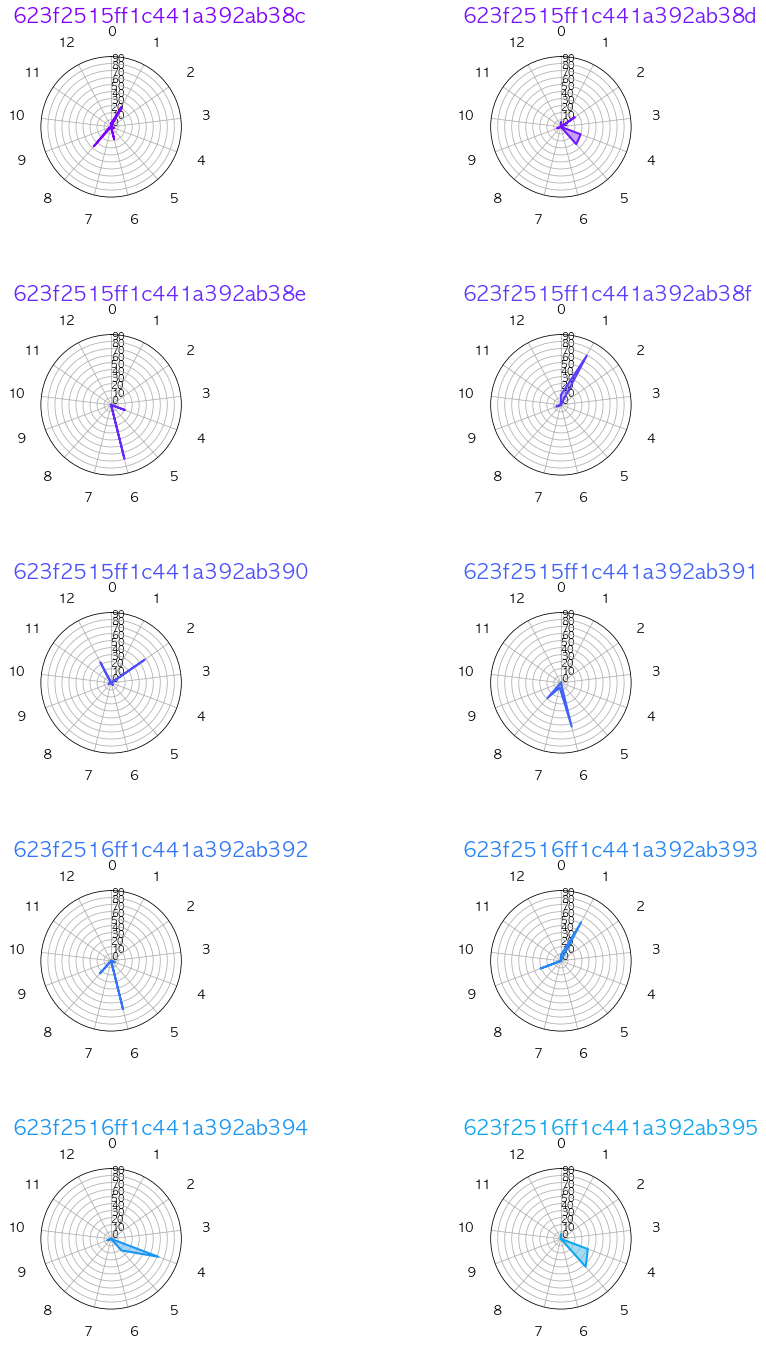

In [67]:
## 따로 그리기
labels = mail_box_radar.columns
num_labels = len(labels)
    
angles = [x/float(num_labels)*(2*pi) for x in range(num_labels)] ## 각 등분점
angles += angles[:1] ## 시작점으로 다시 돌아와야하므로 시작점 추가
    
my_palette = plt.cm.get_cmap("rainbow", len(mail_box_radar))
 
fig = plt.figure(figsize=(15,20))
fig.set_facecolor('white')
 
for i, row in enumerate(mail_box_radar.values[10:20]):
    color = my_palette(i)
    data = row.tolist()
    data += data[:1] # 원점 데이터
    
    ax = plt.subplot(5,2,i+1, polar=True)
    ax.set_theta_offset(pi / 2) ## 시작점
    ax.set_theta_direction(-1) ## 그려지는 방향 시계방향
    
    plt.xticks(angles[:-1], labels, fontsize=13) ## x축 눈금 라벨
    ax.tick_params(axis='x', which='major', pad=15) ## x축과 눈금 사이에 여백을 준다.
 
    ax.set_rlabel_position(0) ## y축 각도 설정(degree 단위)
    plt.yticks(range(0, 100, 10),[str(_) for _ in range(0,100,10)], fontsize=10) ## y축 눈금 설정
    plt.ylim(0,100)
    
    ax.plot(angles, data, color=color, linewidth=2, linestyle='solid') ## 레이더 차트 출력
    ax.fill(angles, data, color=color, alpha=0.4) ## 도형 안쪽에 색을 채워준다.
    
    plt.title(mail_box_radar.index[i], size=20, color=color,x=-0.2, y=1.2, ha='left') ## 타이틀은 캐릭터 클래스로 한다.
 
plt.tight_layout(pad=5) ## subplot간 패딩 조절
plt.show()

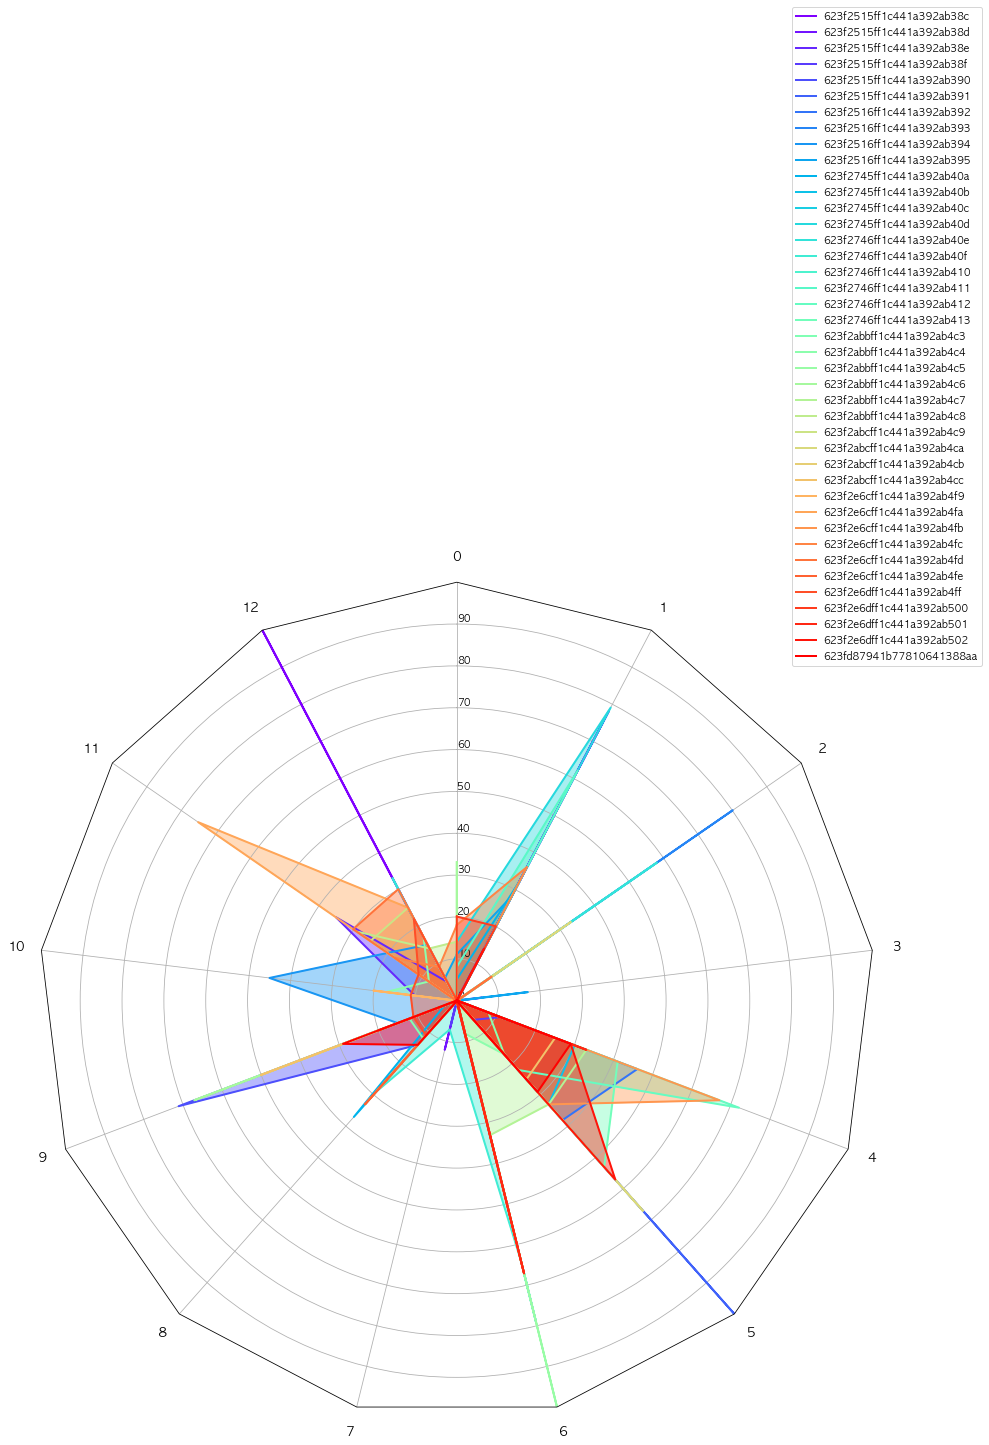

In [68]:
## 따로 그리기
labels = mail_box_radar.columns
num_labels = len(labels)
    
angles = [x/float(num_labels)*(2*pi) for x in range(num_labels)] ## 각 등분점
angles += angles[:1] ## 시작점으로 다시 돌아와야하므로 시작점 추가
    
my_palette = plt.cm.get_cmap("rainbow", len(mail_box_radar))
 
fig = plt.figure(figsize=(15,20))
fig.set_facecolor('white')
ax = fig.add_subplot(polar=True)

for i, row in enumerate(mail_box_radar.values):
    color = my_palette(i)
    data = row.tolist()
    data += data[:1] # 원점 데이터
    
    ax.set_theta_offset(pi / 2) ## 시작점
    ax.set_theta_direction(-1) ## 그려지는 방향 시계방향
    
    plt.xticks(angles[:-1], labels, fontsize=13) ## x축 눈금 라벨
    ax.tick_params(axis='x', which='major', pad=15) ## x축과 눈금 사이에 여백을 준다.
    ax.set_rlabel_position(0) ## y축 각도 설정(degree 단위)
    plt.yticks(range(0, 100, 10),[str(_) for _ in range(0,100,10)], fontsize=10) ## y축 눈금 설정
    plt.ylim(0,100)
    
    ax.plot(angles, data, color=color, linewidth=2, linestyle='solid',
            label=mail_box_radar.index[i]) ## 레이더 차트 출력
    ax.fill(angles, data, color=color, alpha=0.4) ## 도형 안쪽에 색을 채워준다.
    
for g in ax.yaxis.get_gridlines(): ## grid line 
    g.get_path()._interpolation_steps = len(labels)
    
spine = Spine(axes=ax,
          spine_type='circle',
          path=Path.unit_regular_polygon(len(labels)))
 
## Axes의 중심과 반지름을 맞춰준다.
spine.set_transform(Affine2D().scale(.5).translate(.5, .5)+ax.transAxes)
           
ax.spines = {'polar':spine} ## frame의 모양을 원에서 폴리곤으로 바꿔줘야한다.
 
plt.legend(loc=(0.9,0.9))
plt.show()

In [69]:
quadrant_check = [[1, 1], [1, -1],[-1, -1], [-1,1]]

def get_quadrant(angle):
    chk_angle = [0, 90, 180, 270]
    if angle in chk_angle:
        return -1
    else:
        if angle < 90:
            return 0
        elif angle < 180:
            return 1
        elif angle < 270:
            return 2
        elif angle < 360:
            return 3
        
def check_guadrant(angle, point):
    if angle == 0:
        return [0, point[1]]
    elif angle == 90:
        return [point[1],0]
    elif angle == 180:
        return [0, point[1] * -1]
    elif angle == 270:
        return [point[1] * -1, 0]


In [70]:
cent_points = list()
mail_box_ids = mail_box_radar.index.values
for b_id in mail_box_ids:
    test = mail_box_radar.loc[b_id]
    non_zero_labels = test != 0

    sel_idx = test[non_zero_labels].index.values
    x = np.array(angles)[sel_idx]
    y = test[sel_idx].values
    
    point = np.array([[x[i], y[i]] for i,_ in enumerate(x)])
    
    point = point.reshape(-1, 2)

    for idx,pt in enumerate(point):  
        rad = pt[0]
        ang = rad / pi * 180
        dis = pt[1]
        quad = get_quadrant(ang)
        if quad == -1:
            point[idx] = check_guadrant(ang, pt)
        else:
            if (ang < 90) or \
                (ang > 180 and ang < 270):
                ang = 90 - (ang % 90)
            else:
                ang = ang % 90
            rad = ang * pi / 180
            
            quad = quadrant_check[quad]
            x = dis * mt.cos(rad) * quad[0]
            y = dis * mt.sin(rad) * quad[1]
            
            point[idx] = [x,y]
    point = point.reshape(-1, 2)
    point = point.reshape(-1, 2)
    
    cent_points.append(point.sum(axis=0))
    
cent_points = np.array(cent_points)

cent_points

array([[-46.4723172 ,  88.54560257],
       [ 41.91743913,  50.99005571],
       [-17.81898131,  69.78771435],
       [ 49.07642805,  54.84820085],
       [-66.38615323, -46.13524793],
       [ 66.31226582, -74.85107482],
       [ 54.18416454, -50.07430654],
       [ 47.13838442,  38.353082  ],
       [-78.81205458,  21.00565888],
       [ 31.01864162,   6.62248397],
       [ -3.48668241, -14.67409667],
       [ 64.07505033, -17.8330767 ],
       [ 38.54127858, -84.1511062 ],
       [ 30.16801689,  81.46879182],
       [ 31.30962521,  57.75534162],
       [ -5.58956422, -90.64368073],
       [  6.68656582, -89.02875632],
       [ -0.17266686,  51.90552209],
       [ 76.2997705 , -44.12641765],
       [ 73.48116684, -48.20987002],
       [ 21.71111999, -40.18681666],
       [-27.27054172, -20.39543108],
       [ 23.93156643, -97.09418174],
       [-62.64608826,   9.24147257],
       [ 60.63600065, -68.44389594],
       [-20.08208296,   1.11976387],
       [  2.88179146,  14.71138784],
 

In [71]:
max_point = np.identity(len(mail_box_radar.columns)) * 100

angles = [x/float(num_labels)*(2*pi) for x in range(num_labels)] ## 각 등분점
datas = max_point
cent_max_point = np.array([])

for data in datas:
    point = np.array([[angles[_], data[_]] for _ in range(0, len(data))])
    for idx,pt in enumerate(point):  
        rad = pt[0]
        ang = rad / pi * 180
        dis = pt[1]
        
        quad = get_quadrant(ang)
        if quad == -1:
            point[idx] = check_guadrant(ang, pt)
        else:
            if (ang < 90) or \
                (ang > 180 and ang < 270):
                ang = 90 - (ang % 90)
            else:
                ang = ang % 90
            rad = ang * pi / 180

            quad = quadrant_check[quad]
            x = dis * mt.cos(rad) * quad[0]
            y = dis * mt.sin(rad) * quad[1]

            point[idx] = [x,y]
    
    cent_max_point = np.append(cent_max_point,point.sum(axis=0))
    
cent_max_point = cent_max_point.reshape(-1, 2)
cent_max_point

array([[  0.        , 100.        ],
       [ 46.4723172 ,  88.54560257],
       [ 82.29838659,  56.80647467],
       [ 99.27088741,  12.05366803],
       [ 93.50162427, -35.4604887 ],
       [ 66.31226582, -74.85107482],
       [ 23.93156643, -97.09418174],
       [-23.93156643, -97.09418174],
       [-66.31226582, -74.85107482],
       [-93.50162427, -35.4604887 ],
       [-99.27088741,  12.05366803],
       [-82.29838659,  56.80647467],
       [-46.4723172 ,  88.54560257]])

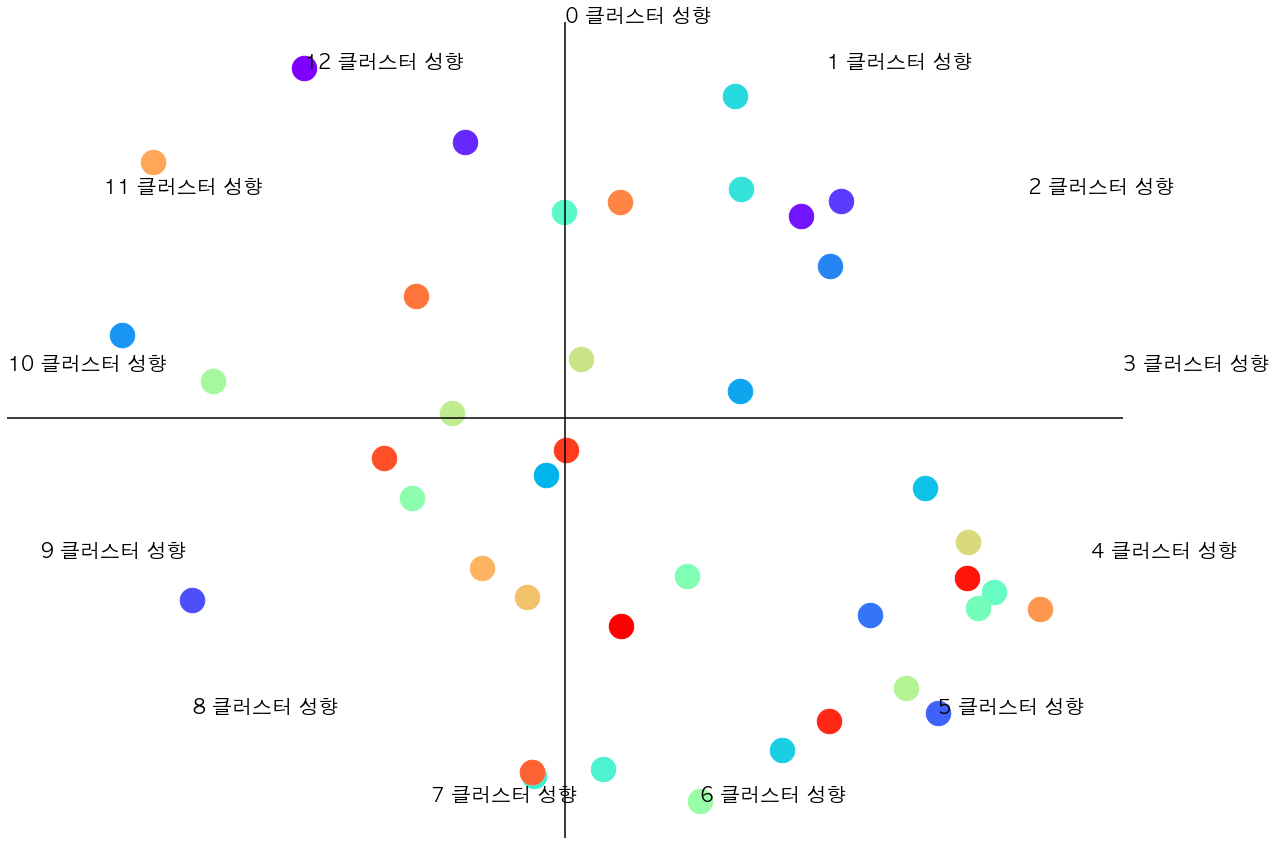

In [72]:
plt.figure(figsize=(20, 15))

for idx, pt in enumerate(cent_points):
    color = my_palette(idx)
    x = pt[0]
    y = pt[1]
    plt.scatter(x, y, s=600, color=color, label=mail_box_radar.index[idx])
    
for idx, pt in enumerate(cent_max_point):
    plt.text(pt[0], pt[1],"{} 클러스터 성향".format(idx), fontsize=20)

plt.xticks([
    cent_max_point[:,0].min(),
    cent_max_point[:,0].max()
])
plt.yticks([
    cent_max_point[:,1].min(),
    cent_max_point[:,1].max()
])

plt.axhline(
    0, color='black'
)
plt.axvline(
    0, color='black'
)
plt.axis("off")
# plt.legend()

plt.show()

In [73]:
mail_box_points = pd.DataFrame(cent_points, columns=['x','y'])

mail_box_points.index = mail_box_ids
mail_box_points

,x,y
623f2515ff1c441a392ab38c,-46.472317,88.545603
623f2515ff1c441a392ab38d,41.917439,50.990056
623f2515ff1c441a392ab38e,-17.818981,69.787714
623f2515ff1c441a392ab38f,49.076428,54.848201
623f2515ff1c441a392ab390,-66.386153,-46.135248
623f2515ff1c441a392ab391,66.312266,-74.851075
623f2516ff1c441a392ab392,54.184165,-50.074307
623f2516ff1c441a392ab393,47.138384,38.353082
623f2516ff1c441a392ab394,-78.812055,21.005659
623f2516ff1c441a392ab395,31.018642,6.622484


# 유사도 확인

In [86]:
rate_x = 100
rate_y = 100

_my_box_id = mail_box_points.iloc[2].name
user_centroid = mail_box_points.iloc[2].values
user_x, user_y = user_centroid

search_box = mail_box_points[
    ((mail_box_points['x'] < (user_x + rate_x)) & (mail_box_points['x'] > (user_x - rate_x))) &
    ((mail_box_points['y'] < (user_y + rate_y)) & (mail_box_points['y'] > (user_y - rate_y)))
]

search_box.head()

,x,y
623f2515ff1c441a392ab38c,-46.472317,88.545603
623f2515ff1c441a392ab38d,41.917439,50.990056
623f2515ff1c441a392ab38e,-17.818981,69.787714
623f2515ff1c441a392ab38f,49.076428,54.848201
623f2516ff1c441a392ab393,47.138384,38.353082


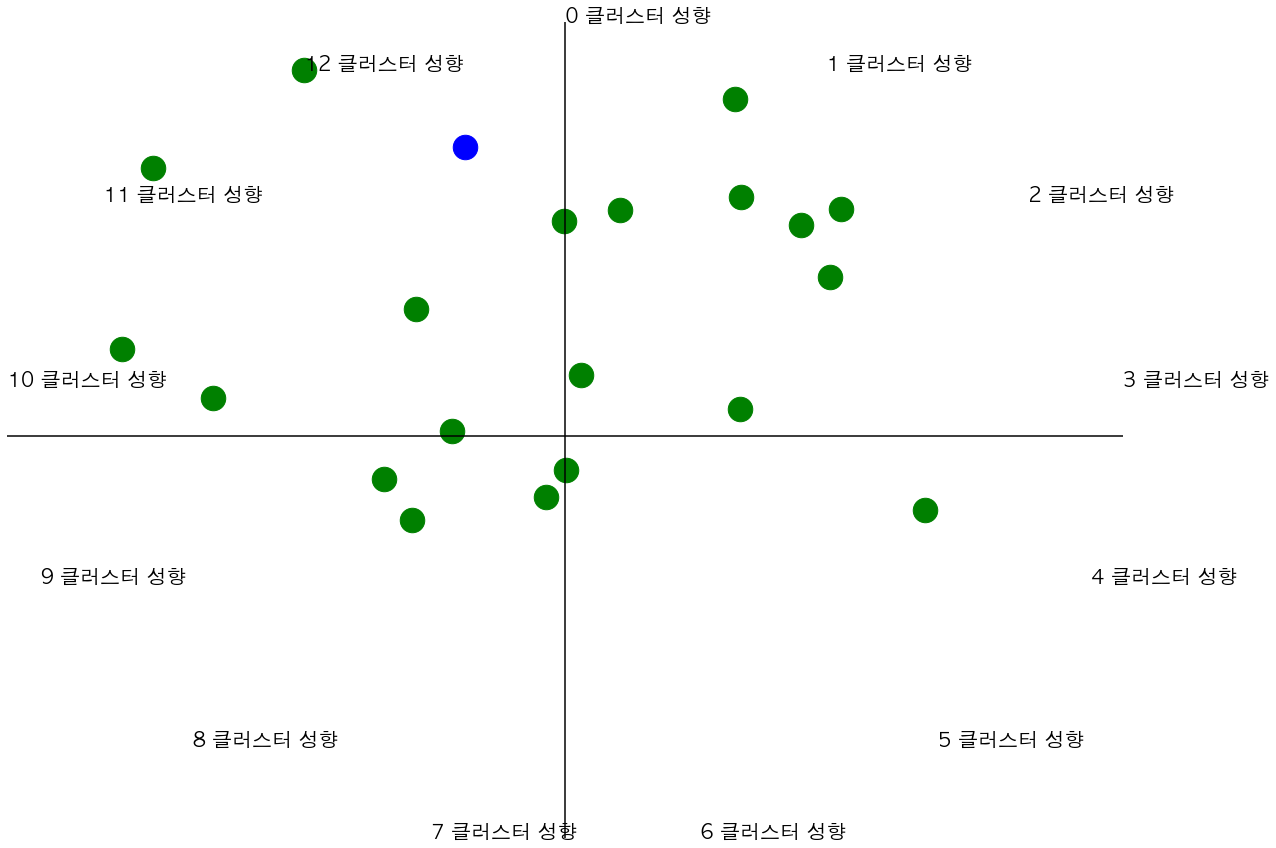

In [87]:
plt.figure(figsize=(20, 15))

for idx, pt in enumerate(search_box.values):
    b_id = search_box.index[idx]
    
    x = pt[0]
    y = pt[1]
    plt.scatter(x, y, s=600, color='b' if b_id == _my_box_id else 'g', label=mail_box_radar.index[idx])
    
for idx, pt in enumerate(cent_max_point):
    plt.text(pt[0], pt[1],"{} 클러스터 성향".format(idx), fontsize=20)

plt.xticks([
    cent_max_point[:,0].min(),
    cent_max_point[:,0].max()
])
plt.yticks([
    cent_max_point[:,1].min(),
    cent_max_point[:,1].max()
])

plt.axhline(
    0, color='black'
)
plt.axvline(
    0, color='black'
)
plt.axis("off")
# plt.legend()

plt.show()

In [88]:
tracks = pd.DataFrame()
reco_ids = list()

for box in mail_boxes:
    _id = box['_id']
    
    if str(_id) in search_box.index:
        _box_tracks = pd.DataFrame(box['tracks'])
        _box_tracks['box_id'] = str(_id)
        
        tracks = pd.concat([tracks,_box_tracks], ignore_index=True)
        reco_ids.append(str(_id))
        
tracks.rename({"track_id": "id"}, axis=1,inplace=True)
tracks.head()

,id,name,artists,artists_name,box_id
0,7tIOwGFRTM08JdAeKOELGp,Blue room,3rxeQlsv0Sc2nyYaZ5W71T,Chet Baker,623f2515ff1c441a392ab38c
1,2yiISACbYnL2hApy1ffKKs,Misty - Remastered 2020,6C65D20ASusYqHGSIktfED,Erroll Garner,623f2515ff1c441a392ab38c
2,79chL6wRWGUCF5V5qKZtf0,Clair de Lune - Debussy,22pAlZRKZ8WyPTtf63Y5nV,Exam Study Classical Music Orchestra,623f2515ff1c441a392ab38c
3,58yFroDNbzHpYzvicaC0de,Peace Piece,4jXfFzeP66Zy67HM2mvIIF,Bill Evans,623f2515ff1c441a392ab38c
4,7KRaeLuGqHJNhU3V3Vw67Z,Dark Night of the Soul,7xaLfXBI5MSy3aNX7m4X3O,Philip Wesley,623f2515ff1c441a392ab38c


In [89]:
merge_features = pd.merge(tracks, norm_features, on="id")

merge_features.head()

,id,name,artists,artists_name,box_id,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,7tIOwGFRTM08JdAeKOELGp,Blue room,3rxeQlsv0Sc2nyYaZ5W71T,Chet Baker,623f2515ff1c441a392ab38c,0.557221,0.030677,0.454545,0.25992,0.08376,0.993969,0.981112,0.119325,0.357399,0.426436
1,7tIOwGFRTM08JdAeKOELGp,Blue room,3rxeQlsv0Sc2nyYaZ5W71T,Chet Baker,623f2515ff1c441a392ab38e,0.557221,0.030677,0.454545,0.25992,0.08376,0.993969,0.981112,0.119325,0.357399,0.426436
2,7tIOwGFRTM08JdAeKOELGp,Blue room,3rxeQlsv0Sc2nyYaZ5W71T,Chet Baker,623f2516ff1c441a392ab394,0.557221,0.030677,0.454545,0.25992,0.08376,0.993969,0.981112,0.119325,0.357399,0.426436
3,7tIOwGFRTM08JdAeKOELGp,Blue room,3rxeQlsv0Sc2nyYaZ5W71T,Chet Baker,623f2516ff1c441a392ab395,0.557221,0.030677,0.454545,0.25992,0.08376,0.993969,0.981112,0.119325,0.357399,0.426436
4,7tIOwGFRTM08JdAeKOELGp,Blue room,3rxeQlsv0Sc2nyYaZ5W71T,Chet Baker,623f2746ff1c441a392ab40e,0.557221,0.030677,0.454545,0.25992,0.08376,0.993969,0.981112,0.119325,0.357399,0.426436


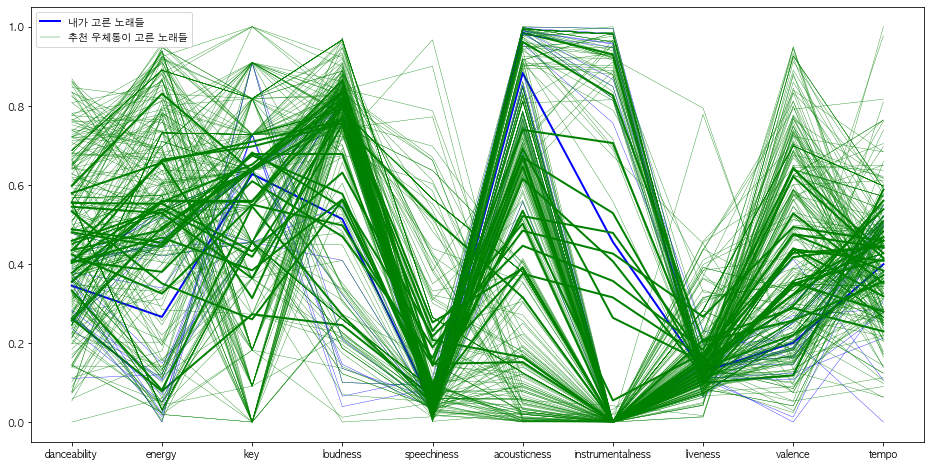

In [90]:
feature_columns = ['danceability',
       'energy', 'key', 'loudness', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo']

plt.figure(figsize=(16,8))

for box_id in reco_ids:
    _features = merge_features[
        merge_features['box_id'] == box_id
    ]
    
    plt.plot(_features[feature_columns].T.mean(axis=1), color='b' if box_id == _my_box_id else 'g',
            linewidth=2, label='내가 고른 노래들' if box_id == _my_box_id else '추천 우체통이 고른 노래들')
    plt.plot(_features[feature_columns].T, color='b' if box_id == _my_box_id else 'g',
            linewidth=0.35)


plt.xticks(feature_columns)
leg = plt.legend(['내가 고른 노래들', '추천 우체통이 고른 노래들'])

leg.legendHandles[0].set_color('blue')
leg.legendHandles[1].set_color('g')

plt.show()

In [91]:
my_features = merge_features[
    merge_features['box_id'] == _my_box_id
]
my_mean = my_features[feature_columns].mean(axis=0).values
my_mean = np.expand_dims(my_mean, axis=0)

reco_features = my_features = merge_features[
    merge_features['box_id'] != _my_box_id
]
reco_features = reco_features[feature_columns].values

print("평균 노래 거리 차이 :",euc(my_mean,
   reco_features)[0].mean())

평균 노래 거리 차이 : 0.9740905050731007


In [92]:
rate_x = 100
rate_y = 100

_my_box_id = mail_box_points.iloc[0].name
user_centroid = mail_box_points.iloc[0].values
user_x, user_y = user_centroid

search_box = mail_box_points[~(
    ((mail_box_points['x'] < (user_x + rate_x)) & (mail_box_points['x'] > (user_x - rate_x))) &
    ((mail_box_points['y'] < (user_y + rate_y)) & (mail_box_points['y'] > (user_y - rate_y)))
)]

search_box = search_box.append(mail_box_points.iloc[0])

search_box.head()

,x,y
623f2515ff1c441a392ab390,-66.386153,-46.135248
623f2515ff1c441a392ab391,66.312266,-74.851075
623f2516ff1c441a392ab392,54.184165,-50.074307
623f2745ff1c441a392ab40a,-3.486682,-14.674097
623f2745ff1c441a392ab40b,64.075050,-17.833077


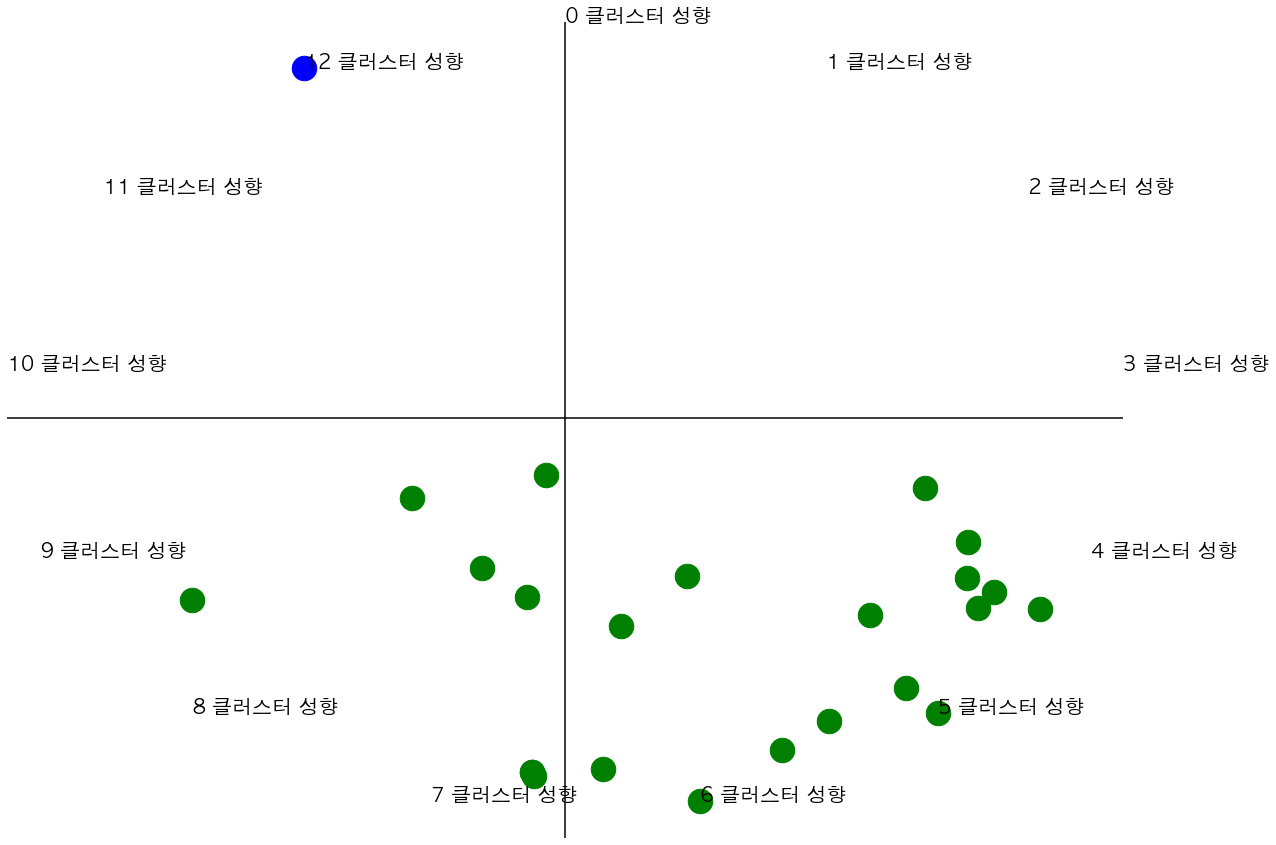

In [93]:
plt.figure(figsize=(20, 15))

for idx, pt in enumerate(search_box.values):
    b_id = search_box.index[idx]
    
    x = pt[0]
    y = pt[1]
    plt.scatter(x, y, s=600, color='b' if b_id == _my_box_id else 'g', label=mail_box_radar.index[idx])
    
for idx, pt in enumerate(cent_max_point):
    plt.text(pt[0], pt[1],"{} 클러스터 성향".format(idx), fontsize=20)

plt.xticks([
    cent_max_point[:,0].min(),
    cent_max_point[:,0].max()
])
plt.yticks([
    cent_max_point[:,1].min(),
    cent_max_point[:,1].max()
])

plt.axhline(
    0, color='black'
)
plt.axvline(
    0, color='black'
)
plt.axis("off")
# plt.legend()

plt.show()

In [94]:
tracks = pd.DataFrame()
reco_ids = list()

for box in mail_boxes:
    _id = box['_id']
    
    if str(_id) in search_box.index:
        _box_tracks = pd.DataFrame(box['tracks'])
        _box_tracks['box_id'] = str(_id)
        
        tracks = pd.concat([tracks,_box_tracks], ignore_index=True)
        reco_ids.append(str(_id))
        
tracks.rename({"track_id": "id"}, axis=1,inplace=True)
tracks.head()

,id,name,artists,artists_name,box_id
0,7tIOwGFRTM08JdAeKOELGp,Blue room,3rxeQlsv0Sc2nyYaZ5W71T,Chet Baker,623f2515ff1c441a392ab38c
1,2yiISACbYnL2hApy1ffKKs,Misty - Remastered 2020,6C65D20ASusYqHGSIktfED,Erroll Garner,623f2515ff1c441a392ab38c
2,79chL6wRWGUCF5V5qKZtf0,Clair de Lune - Debussy,22pAlZRKZ8WyPTtf63Y5nV,Exam Study Classical Music Orchestra,623f2515ff1c441a392ab38c
3,58yFroDNbzHpYzvicaC0de,Peace Piece,4jXfFzeP66Zy67HM2mvIIF,Bill Evans,623f2515ff1c441a392ab38c
4,7KRaeLuGqHJNhU3V3Vw67Z,Dark Night of the Soul,7xaLfXBI5MSy3aNX7m4X3O,Philip Wesley,623f2515ff1c441a392ab38c


In [95]:
merge_features = pd.merge(tracks, norm_features, on="id")

merge_features.head()

,id,name,artists,artists_name,box_id,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,7tIOwGFRTM08JdAeKOELGp,Blue room,3rxeQlsv0Sc2nyYaZ5W71T,Chet Baker,623f2515ff1c441a392ab38c,0.557221,0.030677,0.454545,0.259920,0.083760,0.993969,0.981112,0.119325,0.357399,0.426436
1,7tIOwGFRTM08JdAeKOELGp,Blue room,3rxeQlsv0Sc2nyYaZ5W71T,Chet Baker,623f2abbff1c441a392ab4c4,0.557221,0.030677,0.454545,0.259920,0.083760,0.993969,0.981112,0.119325,0.357399,0.426436
2,7tIOwGFRTM08JdAeKOELGp,Blue room,3rxeQlsv0Sc2nyYaZ5W71T,Chet Baker,623f2e6cff1c441a392ab4f9,0.557221,0.030677,0.454545,0.259920,0.083760,0.993969,0.981112,0.119325,0.357399,0.426436
3,2yiISACbYnL2hApy1ffKKs,Misty - Remastered 2020,6C65D20ASusYqHGSIktfED,Erroll Garner,623f2515ff1c441a392ab38c,0.141689,0.140150,0.454545,0.265490,0.036117,0.949746,0.927597,0.093277,0.117103,0.809968
4,79chL6wRWGUCF5V5qKZtf0,Clair de Lune - Debussy,22pAlZRKZ8WyPTtf63Y5nV,Exam Study Classical Music Orchestra,623f2515ff1c441a392ab38c,0.220708,0.042931,0.090909,0.219294,0.071465,0.994975,0.939140,0.094642,0.023921,0.540853


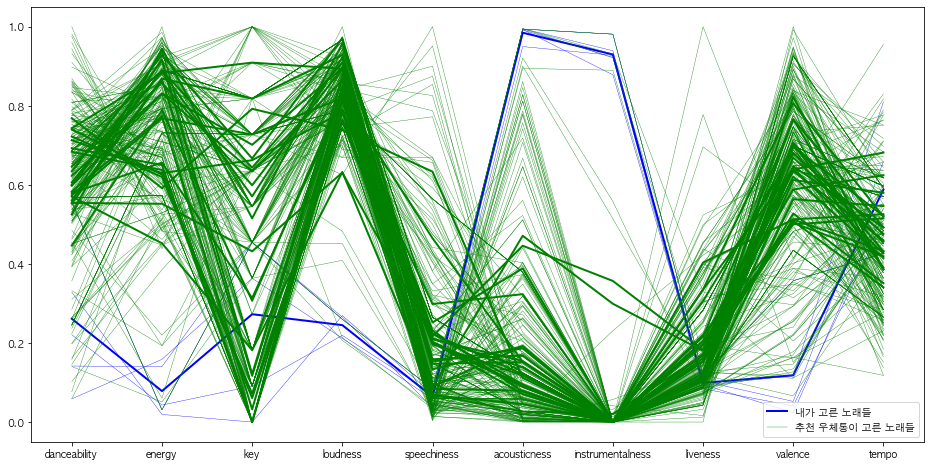

In [96]:
feature_columns = ['danceability',
       'energy', 'key', 'loudness', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo']

plt.figure(figsize=(16,8))

for box_id in reco_ids:
    _features = merge_features[
        merge_features['box_id'] == box_id
    ]
    
    plt.plot(_features[feature_columns].T.mean(axis=1), color='b' if box_id == _my_box_id else 'g',
            linewidth=2, label='내가 고른 노래들' if box_id == _my_box_id else '추천 우체통이 고른 노래들')
    plt.plot(_features[feature_columns].T, color='b' if box_id == _my_box_id else 'g',
            linewidth=0.35)


plt.xticks(feature_columns)
leg = plt.legend(['내가 고른 노래들', '추천 우체통이 고른 노래들'])

leg.legendHandles[0].set_color('blue')
leg.legendHandles[1].set_color('g')

plt.show()

In [97]:
my_features = merge_features[
    merge_features['box_id'] == _my_box_id
]
my_mean = my_features[feature_columns].mean(axis=0).values
my_mean = np.expand_dims(my_mean, axis=0)

reco_features = my_features = merge_features[
    merge_features['box_id'] != _my_box_id
]
reco_features = reco_features[feature_columns].values

print("평균 노래 거리 차이 :",euc(my_mean,
   reco_features)[0].mean())

평균 노래 거리 차이 : 1.733654970116728
